In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from random import randrange

from skimage import io

In [49]:
img_ = cv2.imread('/Users/ismail/Desktop/q11.jpg')
#img1 = cv2.cvtColor(img_,cv2.COLOR_BGR2GRAY)
img = cv2.imread('/Users/ismail/Desktop/q22.jpg')
#img2 = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

In [50]:
sift = cv2.xfeatures2d.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img_,None)
kp2, des2 = sift.detectAndCompute(img,None)

In [51]:
bf = cv2.BFMatcher()
matches = bf.knnMatch(des1,des2, k=4)

In [52]:
# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.7*m[1].distance:
        good.append(m)
matches = np.asarray(good)

In [53]:
if len(matches[:,0]) >= 4:
    src = np.float32([ kp1[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kp2[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
    
#print H
else:
    raise AssertionError('Can not find enough keypoints.')
    

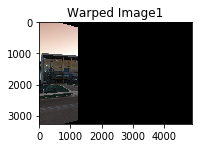

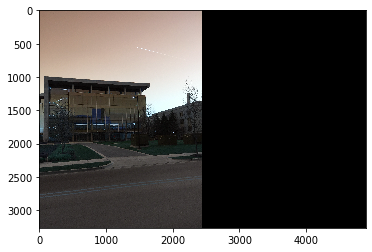

In [54]:
dst = cv2.warpPerspective(img_,H,(img.shape[1] + img_.shape[1], img.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image1')
plt.show()
plt.figure()
dst[0:img.shape[0], 0:img.shape[1]] = img
cv2.imwrite('/Users/ismail/Desktop/output1.jpg',dst)
plt.imshow(dst)
plt.show()

In [146]:
from PIL import Image
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io

In [386]:
image1 = mpimg.imread('/Users/ismail/Desktop/image1.jpg')
image2 = mpimg.imread('/Users/ismail/Desktop/image2.jpg')
images = [image1, image2]

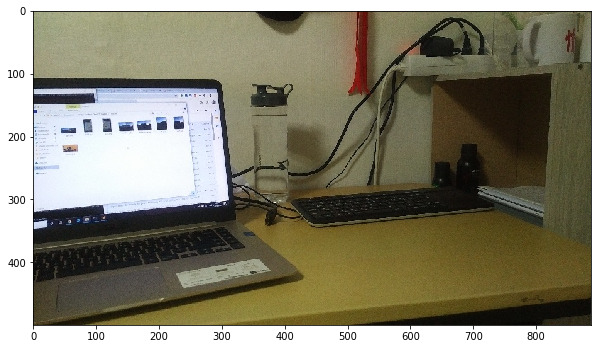

In [387]:
# Display one image
plt.figure(figsize=(10,10))
plt.imshow(image1)
plt.imshow(image2)

In [388]:
sift = cv2.xfeatures2d.SIFT_create()
# Find the key points and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(image1, None)
kp2, des2 = sift.detectAndCompute(image2, None)

In [389]:
kp_image1 = cv2.drawKeypoints(image1, kp1, None)
kp_image2 = cv2.drawKeypoints(image2, kp2, None)

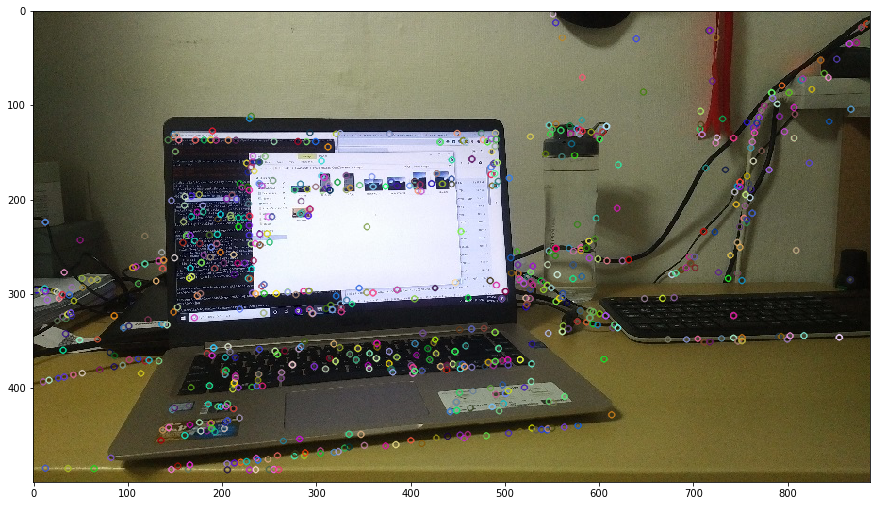

In [390]:
plt.figure(figsize=(15,10))
plt.imshow(kp_image1)

In [391]:
ratio = 0.55
min_match = 10

matcher = cv2.BFMatcher()
raw_matches = matcher.knnMatch(des1, des2, k=2)
good_points = []
good_matches = []
for m1, m2 in raw_matches:
    if m1.distance < ratio * m2.distance:
        good_points.append((m1.trainIdx, m1.queryIdx))
        good_matches.append([m1])
matches = cv2.drawMatchesKnn(image1, kp1, image2, kp2, good_matches, None, flags=2)

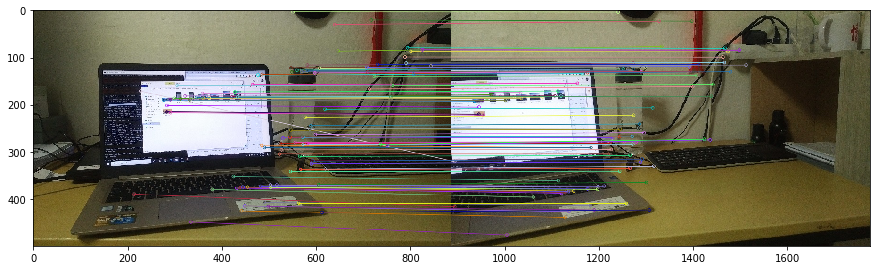

In [392]:
plt.figure(figsize=(15,10))
plt.imshow(matches)

In [393]:
if len(good_points) > min_match:
    image1_kp = np.float32(
        [kp1[i].pt for (_, i) in good_points])
    image2_kp = np.float32(
        [kp2[i].pt for (i, _) in good_points])
    H, status = cv2.findHomography(image2_kp, image1_kp, cv2.RANSAC, 1.0)      # RANSAC

In [394]:
def create_mask(img1,img2,version):
    height_img1 = img1.shape[0]
    width_img1 = img1.shape[1]
    width_img2 = img2.shape[1]
    height_panorama = height_img1
    width_panorama = width_img1 + width_img2
    offset = int(smoothing_window_size / 2)
    barrier = img1.shape[1] - int(smoothing_window_size / 2)
    mask = np.zeros((height_panorama, width_panorama))
    if version== 'left_image':
        mask[:, barrier - offset:barrier + offset ] = np.tile(np.linspace(1, 0, 2 * offset ).T, (height_panorama, 1))
        mask[:, :barrier - offset] = 1
    else:
        mask[:, barrier - offset :barrier + offset ] = np.tile(np.linspace(0, 1, 2 * offset ).T, (height_panorama, 1))
        mask[:, barrier + offset:] = 1
    return cv2.merge([mask, mask, mask])

In [395]:
smoothing_window_size = 100
# H = registration(img1,img2)
height_img1 = image1.shape[0]
width_img1 = image1.shape[1]
width_img2 = image2.shape[1]
height_panorama = height_img1
width_panorama = width_img1 + width_img2

panorama1 = np.zeros((height_panorama, width_panorama, 3))
mask1 = create_mask(image1, image2, version='left_image')
panorama1[0:image1.shape[0], 0:image1.shape[1], :] = image1
panorama1 *= mask1
mask2 = create_mask(image1,image2,version='right_image')
panorama2 = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))*mask2
result = panorama1 + panorama2


rows, cols = np.where(result[:, :, 0] != 0)
min_row, max_row = min(rows), max(rows) + 1
min_col, max_col = min(cols), max(cols) + 1
final_result = result[min_row:max_row, min_col:max_col, :]

In [396]:
test = cv2.warpPerspective(image2, H, (width_panorama, height_panorama))

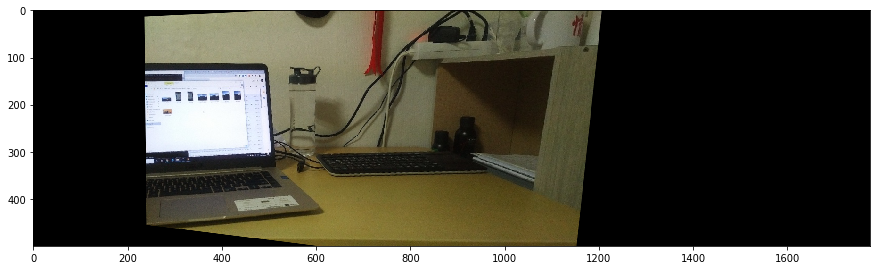

In [397]:
plt.figure(figsize=(15,15))
plt.imshow(test/255.0)

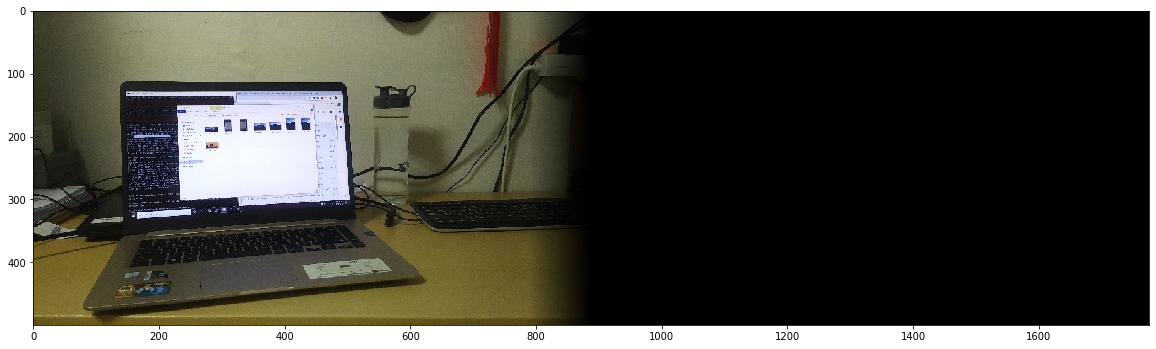

In [398]:
plt.figure(figsize=(20,20))
plt.imshow(panorama1/255.0)

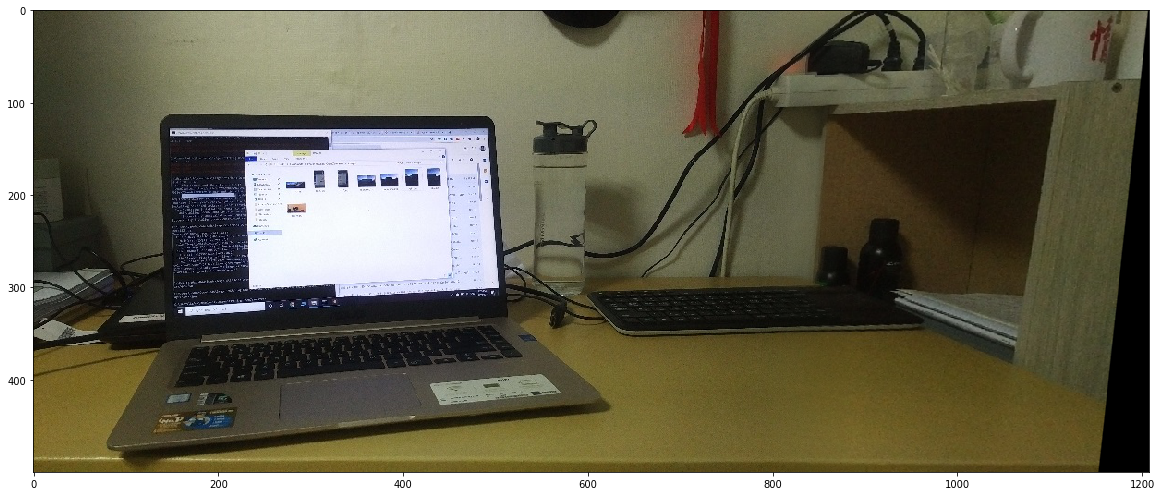

In [399]:
plt.figure(figsize=(20,20))
plt.imshow(final_result/255.0)

In [400]:
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

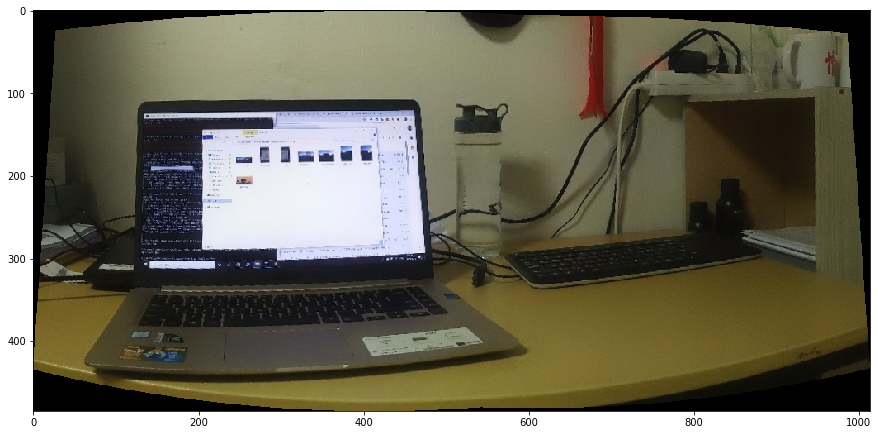

In [401]:
plt.figure(figsize=(15,10))

#cv2.imwrite('/Users/ismail/Desktop/final.jpg')
#cv2.imshow('/Users/ismail/Desktop/images/left.jpg',stitched)
plt.imshow(stitched)

In [402]:
(status_1, stitched_1) = stitcher.stitch([image1, image2])

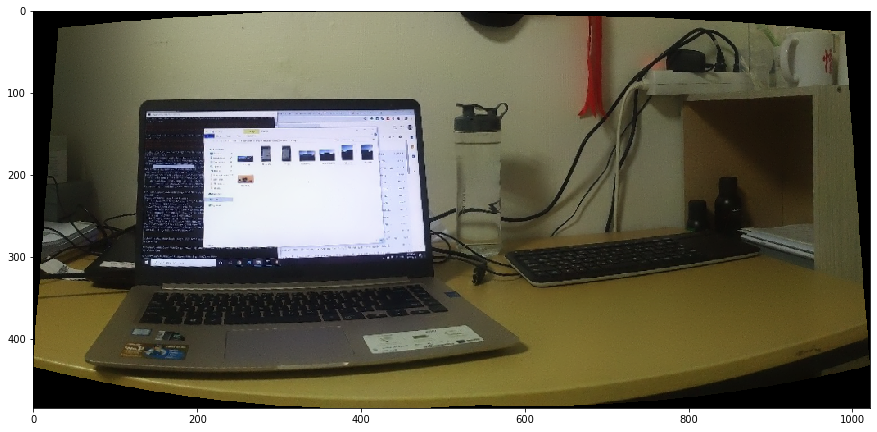

In [403]:
plt.figure(figsize=(15,10))
plt.imshow(stitched_1)

In [ ]:
import cv2
cv2.__version__

In [257]:
from imutils import paths
import numpy as np
import argparse
import imutils
import cv2
from PIL import Image

In [258]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [259]:
image1 = mpimg.imread('/Users/ismail/Desktop/images/right.jpg')
image2 = mpimg.imread('/Users/ismail/Desktop/images/left.jpg')
images = [image1, image2]

In [260]:
stitcher = cv2.createStitcher() if imutils.is_cv3() else cv2.Stitcher_create()
(status, stitched) = stitcher.stitch(images)

TypeError: Image data of dtype object cannot be converted to float

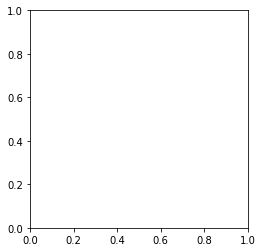

In [261]:
plt.imshow(stitched)
#plt.imshow(image2np(stitched))